In [2]:
# prompt: code to prevent run time disconnect

# This code will keep the Colab runtime active by periodically sending a request to the server.

import time
import IPython

display(IPython.display.Javascript('''
function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,600)
'''))

print("Colab will remain active. Do not close this tab.")

<IPython.core.display.Javascript object>

Colab will remain active. Do not close this tab.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK./root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1
# /content/labels_with_dont_care
import kagglehub
klemenko_kitti_dataset_path = kagglehub.dataset_download('klemenko/kitti-dataset')

print('Data source import complete.')


100%|██████████| 22.5G/22.5G [04:12<00:00, 95.7MB/s]

Extracting files...


Data source import complete.


In [4]:
print(klemenko_kitti_dataset_path)




/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1


In [5]:
import os
import shutil
import yaml
import random
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

# Import YOLOv7 library
import sys
sys.path.append('yolov7')  # Add YOLOv7 to the path


# 1. Setup and Configuration

In [6]:
import torch
from pathlib import Path
import os

# KITTI dataset configuration
KITTI_BASE_DIR = '/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1'
"""str: The base directory where the KITTI dataset is located."""

IMAGE_DIR = Path(KITTI_BASE_DIR) / 'data_object_image_2' / 'training' / 'image_2'
"""Path: Directory containing KITTI training images."""

LABEL_DIR = Path(KITTI_BASE_DIR) / 'data_object_label_2' / 'training' / 'label_2'
"""Path: Directory containing KITTI training labels."""

TRAIN_DIR = Path(KITTI_BASE_DIR)/'train'
"""Path: Directory where training images and labels will be stored in YOLOv7 format."""

VALID_DIR = Path(KITTI_BASE_DIR)/'valid'
"""Path: Directory where validation images and labels will be stored in YOLOv7 format."""

LABELS_DIR = Path(KITTI_BASE_DIR)/'labels_with_dont_care'
"""Path: Directory where YOLOv7-formatted labels will be stored."""

CLASSES = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
    'Cyclist', 'Tram', 'Misc', 'DontCare'
]
"""
list of str: List of class names included in the KITTI dataset.
'CLASSES' should reflect all possible object categories for detection.
"""

# YOLOv7 model configuration
WEIGHTS = 'yolov7.pt'  # Pretrained weights for YOLOv7
"""str: Path to the YOLOv7 pretrained weights file."""

EPOCHS = 50
"""int: Number of epochs for training. Adjust this value based on dataset size and desired training time."""

BATCH_SIZE = 16
"""int: Batch size used during training. Adjust based on GPU memory constraints."""

IMG_SIZE = 640
"""int: The size (height and width) of the input images for the model."""

CONFIDENCE_THRESHOLD = 0.25
"""float: The confidence threshold for predictions during validation and testing."""

PROJECT_NAME = 'YOLOv7-KITTI'
"""str: The name of the project folder where YOLOv7 results will be saved."""

EXPERIMENT_NAME = 'exp1'
"""str: The name of the experiment folder within the project directory to store this run's results."""

device = 'cuda' if torch.cuda.is_available() else 'cpu'
"""str: The device to use for training and inference, defaults to GPU if available."""

print(f"Using device: {device}")

# Define the path for the data.yaml file for YOLOv7
DATA_CONFIG_PATH = '/content/data.yaml'

# Prepare the data.yaml file with necessary paths and class names for YOLOv7
data_config = {
    'train': str(Path(TRAIN_DIR).resolve()),
    'val': str(Path(VALID_DIR).resolve()),
    'nc': len(CLASSES),
    'names': CLASSES
}

# Write the data.yaml configuration for YOLOv7
with open(DATA_CONFIG_PATH, 'w', encoding='utf-8') as f:
    yaml.dump(data_config, f, default_flow_style=False)

# Print out the data.yaml content for verification
print(f"data.yaml content:\n{data_config}")

# YOLOv7 Training Command
# Modify this line to execute the YOLOv7 training
os.system(f"""
python train.py --weights {WEIGHTS} \
--cfg ./models/yolov7.yaml \
--data {DATA_CONFIG_PATH} \
--epochs {EPOCHS} \
--batch-size {BATCH_SIZE} \
--img-size {IMG_SIZE} \
--project {PROJECT_NAME} \
--name {EXPERIMENT_NAME} \
--device {device} \
--exist-ok
""")


Using device: cuda
data.yaml content:
{'train': '/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train', 'val': '/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid', 'nc': 9, 'names': ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']}


512

# 2. Data Preparation Functions

In [7]:
import os
from PIL import Image
from pathlib import Path

# Class names for KITTI dataset
CLASSES = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
    'Cyclist', 'Tram', 'Misc', 'DontCare'
]
"""
List of class names included in the KITTI dataset.
'CLASSES' should reflect all possible object categories for detection.
"""

CLAZZ_NUMBERS = {name: idx for idx, name in enumerate(CLASSES)}
"""
dict: A mapping from class names to numeric labels.
The numeric labels are used by YOLO for class indices.
"""

def convert_bbox_to_yolo(bbox, size):
    """
    Convert KITTI bounding box coordinates to YOLO format.

    Args:
        bbox (tuple of float): Bounding box coordinates in the format (left, right, top, bottom).
        size (tuple of int): Image size as (width, height).

    Returns:
        tuple of float: YOLO-formatted bounding box as (x_center, y_center, width, height) normalized by image size.
    """
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x_center = (bbox[0] + bbox[1]) / 2.0
    y_center = (bbox[2] + bbox[3]) / 2.0
    width = bbox[1] - bbox[0]
    height = bbox[3] - bbox[2]
    x_center *= dw
    width *= dw
    y_center *= dh
    height *= dh
    return x_center, y_center, width, height

def parse_kitti_label_file(lbl_path, img_path):
    """
    Parse a KITTI label file and convert the bounding boxes to YOLOv7 format.

    Args:
        lbl_path (Path): Path to the KITTI label file (in KITTI text format).
        img_path (Path): Path to the corresponding image file.

    Returns:
        list of tuple: A list of YOLOv7-formatted bounding boxes. Each element is
        (class_idx, x_center, y_center, width, height).
    """
    with open(lbl_path, 'r', encoding='utf-8') as file:
        lines = file.read().strip().split('\n')

    yolo_labels = []
    if not img_path.exists():
        # If the image doesn't exist, skip processing labels
        return yolo_labels

    img_size = Image.open(img_path).size  # (width, height)

    for line in lines:
        parts = line.split()
        clazz = parts[0]
        if clazz not in CLAZZ_NUMBERS:
            # Skip classes not in our mapping
            continue

        # KITTI format:
        # type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom, ...
        # Indices:  0    ,    1     ,   2     ,   3  ,    4     ,    5    ,     6     ,      7    ...
        # Example: Car 0.00 0 1.57 148.00 174.00 350.00 325.00 ...
        # The bounding box coordinates: left = parts[4], top = parts[5], right = parts[6], bottom = parts[7]
        bbox_left = float(parts[4])
        bbox_top = float(parts[5])
        bbox_right = float(parts[6])
        bbox_bottom = float(parts[7])
        bbox = (bbox_left, bbox_right, bbox_top, bbox_bottom)

        # Convert bounding box to YOLO format (normalized)
        x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_size)
        clazz_number = CLAZZ_NUMBERS[clazz]

        # YOLOv7 format: class x_center y_center width height
        yolo_labels.append((clazz_number, x_center, y_center, width, height))

    return yolo_labels






# 3. Generate YOLO labels

In [8]:
from pathlib import Path

# Check if the labels directory exists, create it if not
if not LABELS_DIR.exists():
    LABELS_DIR.mkdir(parents=True, exist_ok=True)

# Sort image and label paths
image_paths = sorted(list(IMAGE_DIR.glob('*.png')))
label_paths = sorted(list(LABEL_DIR.glob('*.txt')))

# Process each image and its corresponding label file
for img_path in image_paths:
    lbl_path = LABEL_DIR / f"{img_path.stem}.txt"

    # Ensure that the label file exists
    if lbl_path.exists():
        # Parse KITTI label to YOLOv7 format
        yolo_labels = parse_kitti_label_file(lbl_path, img_path)

        # Define the output label file path
        yolo_label_path = LABELS_DIR / f"{img_path.stem}.txt"

        # Write the YOLOv7-formatted labels to the label file
        with open(yolo_label_path, 'w', encoding='utf-8') as lf:
            for lbl in yolo_labels:
                # Write each label with 6 decimal places for each value
                lf.write(" ".join(f"{val:.6f}" for val in lbl) + "\n")

print(f"YOLO format labels have been generated in: {LABELS_DIR.resolve()}")


YOLO format labels have been generated in: /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/labels_with_dont_care


# 4. Split Dataset into Train and Validation Sets

In [9]:
import shutil
from sklearn.model_selection import train_test_split

# Create a list of image and label pairs for labels that exist in LABELS_DIR
labels_for_images = [(img_path, LABELS_DIR / f"{img_path.stem}.txt")
                     for img_path in image_paths
                     if (LABELS_DIR / f"{img_path.stem}.txt").exists()]

# Split the dataset into training and validation sets
train_pairs, valid_pairs = train_test_split(
    labels_for_images,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

# Print the number of training and validation samples
print(f"Training samples: {len(train_pairs)}, Validation samples: {len(valid_pairs)}")

# Create directories for YOLOv7 data structure (images and labels)
for folder in [TRAIN_DIR, VALID_DIR]:
    if folder.exists():
        shutil.rmtree(folder)  # Remove existing folder contents
    folder.mkdir(parents=True, exist_ok=True)  # Create the folder
    (folder / 'images').mkdir(parents=True, exist_ok=True)  # Create images subfolder
    (folder / 'labels').mkdir(parents=True, exist_ok=True)  # Create labels subfolder

# Copy images and labels to the training folder
for img_path, lbl_path in train_pairs:
    shutil.copy(img_path, TRAIN_DIR / 'images' / img_path.name)  # Copy image
    shutil.copy(lbl_path, TRAIN_DIR / 'labels' / lbl_path.name)  # Copy label

# Copy images and labels to the validation folder
for img_path, lbl_path in valid_pairs:
    shutil.copy(img_path, VALID_DIR / 'images' / img_path.name)  # Copy image
    shutil.copy(lbl_path, VALID_DIR / 'labels' / lbl_path.name)  # Copy label

# Print where the data is copied
print(f"Training data copied to {TRAIN_DIR / 'images'} and {TRAIN_DIR / 'labels'}")
print(f"Validation data copied to {VALID_DIR / 'images'} and {VALID_DIR / 'labels'}")


Training samples: 6732, Validation samples: 749
Training data copied to /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train/images and /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train/labels
Validation data copied to /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/images and /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/labels


# 5. Create data.yaml File for YOLO

In [10]:
import yaml
from pathlib import Path

# Define the class names for the KITTI dataset
CLASSES = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
    'Cyclist', 'Tram', 'Misc', 'DontCare'
]
"""
list of str: List of class names in the KITTI dataset.
"""

# Define the directories for training and validation images
TRAIN_IMAGES_DIR = Path(KITTI_BASE_DIR) / 'train' / 'images'
VALID_IMAGES_DIR = Path(KITTI_BASE_DIR) / 'valid' / 'images'

# Define the path for the data.yaml file
YOLOV7_DATA_CONFIG_PATH = Path(KITTI_BASE_DIR) / 'yolov7_data.yaml'

# Prepare the data configuration dictionary for YOLOv7
yolov7_data_config = {
    'train': str(TRAIN_IMAGES_DIR.resolve()),  # Absolute path to training images
    'val': str(VALID_IMAGES_DIR.resolve()),   # Absolute path to validation images
    'nc': len(CLASSES),                       # Number of classes
    'names': CLASSES                          # List of class names
}

# Write the data configuration to the yolov7_data.yaml file
with open(YOLOV7_DATA_CONFIG_PATH, 'w', encoding='utf-8') as f:
    yaml.dump(yolov7_data_config, f, default_flow_style=False)

# Output the content of the generated yolov7_data.yaml file
print("YOLOv7 data.yaml file created with content:")
print(yolov7_data_config)


YOLOv7 data.yaml file created with content:
{'train': '/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train/images', 'val': '/root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/images', 'nc': 9, 'names': ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']}


In [11]:

!pip install yolov8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d7628baf5415b43765f3e1efbdfef0096b60fdc14b44bf5199817228f81c5cb6
  Stored in d

# 6. Train the YOLO11 Model

MODEL ARCHITECTURE


In [12]:
# Install YOLOv8
!pip install ultralytics  # Install the ultralytics library for YOLOv8

# Import the library and check setup
from ultralytics import YOLO
import torch

# Print system and environment information
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete. Using torch 2.5.1+cu121 (Tesla T4)


In [13]:
!pip install ultralytics -q

In [14]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import cv2

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

In [15]:
from ultralytics import YOLO
import torch
import os

# Define configuration
MODEL_ARCH = 'yolov8n.pt'  # YOLOv8 Nano model (change to 'yolov8s.pt', 'yolov8m.pt', etc., for other versions)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the training parameters
DATA_CONFIG = '/content/data.yaml'  # Path to the data.yaml file
EPOCHS = 30  # Reduced epochs to 30 for faster training
BATCH_SIZE = 16  # Batch size (adjust based on GPU resources)
IMG_SIZE = 512  # Reduced image size to 512 for faster processing
CONFIDENCE_THRESHOLD = 0.25  # Confidence threshold for validation

PROJECT_NAME = 'YOLOv8-KITTI'  # Project folder name
EXPERIMENT_NAME = 'exp1'  # Experiment name

# Path to weights
weights_dir = f'{PROJECT_NAME}/{EXPERIMENT_NAME}/weights'
last_weights_path = os.path.join(weights_dir, 'last.pt')

# Check if a checkpoint exists
resume_training = os.path.exists(last_weights_path)

# Initialize the model
if resume_training:
    print(f"Resuming training from checkpoint: {last_weights_path}")
    model = YOLO(last_weights_path)  # Resume from the last checkpoint
else:
    print(f"Starting fresh training with model: {MODEL_ARCH}")
    model = YOLO(MODEL_ARCH)  # Start fresh training

# Train the model
try:
    train_results = model.train(
        data=DATA_CONFIG,
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        imgsz=IMG_SIZE,
        project=PROJECT_NAME,
        name=EXPERIMENT_NAME,
        device=device,
        save_period=5,  # Save checkpoints every 5 epochs
        exist_ok=True  # Avoid overwriting existing experiments
    )
    print("\nTraining completed!\n")

except Exception as e:
    print(f"\nTraining interrupted due to: {e}\n")
    print("Attempting to save progress...")
    # Save the current model state
    if hasattr(model, 'save'):
        model.save(last_weights_path)
        print(f"Progress saved at {last_weights_path}")

# Summary of training
print(f"Project directory: {PROJECT_NAME}/{EXPERIMENT_NAME}")
if resume_training:
    print(f"Resumed from checkpoint: {last_weights_path}")
else:
    print("Training started from scratch.")


Starting fresh training with model: yolov8n.pt


100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]


Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=5, cache=False, device=cuda, workers=8, project=YOLOv8-KITTI, name=exp1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 20.4MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.7MB/s]


AMP: checks passed ✅


train: Scanning /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train/labels... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:39<00:00, 168.52it/s]


train: New cache created: /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/labels... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:05<00:00, 143.54it/s]

val: New cache created: /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/labels.cache


Plotting labels to YOLOv8-KITTI/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to YOLOv8-KITTI/exp1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.57G      1.566      1.946      1.094        245        512: 100%|██████████| 421/421 [02:46<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


                   all        749       5425      0.435      0.301      0.288      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       1.7G      1.428      1.256      1.061        158        512: 100%|██████████| 421/421 [02:42<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


                   all        749       5425      0.349      0.363      0.354      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.53G      1.373       1.12      1.052        125        512: 100%|██████████| 421/421 [02:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


                   all        749       5425      0.531      0.359      0.374      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.59G      1.347       1.05      1.041        174        512: 100%|██████████| 421/421 [02:41<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.33it/s]


                   all        749       5425      0.461      0.412      0.419      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.51G      1.304     0.9841      1.027        158        512: 100%|██████████| 421/421 [02:39<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


                   all        749       5425      0.546      0.436       0.46      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.59G      1.276     0.9439      1.016        195        512: 100%|██████████| 421/421 [02:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


                   all        749       5425      0.552      0.466      0.491      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.71G      1.262      0.914      1.014        196        512: 100%|██████████| 421/421 [02:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.49it/s]


                   all        749       5425      0.634      0.468      0.526      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.65G      1.236     0.8827      1.006        160        512: 100%|██████████| 421/421 [02:36<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


                   all        749       5425      0.584      0.482      0.521      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.55G      1.219     0.8692      1.001        179        512: 100%|██████████| 421/421 [02:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


                   all        749       5425      0.627      0.486      0.557      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.59G      1.204     0.8456     0.9949        201        512: 100%|██████████| 421/421 [02:39<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


                   all        749       5425      0.658      0.491      0.556      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.79G      1.191     0.8309     0.9882        194        512: 100%|██████████| 421/421 [02:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.60it/s]

                   all        749       5425      0.646      0.526       0.59      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.61G      1.174     0.8109     0.9857        138        512: 100%|██████████| 421/421 [02:39<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.35it/s]


                   all        749       5425      0.662      0.535       0.59      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.57G      1.162     0.7986     0.9799        181        512: 100%|██████████| 421/421 [02:34<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


                   all        749       5425      0.697      0.529      0.601      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       1.7G      1.147      0.779     0.9753        155        512: 100%|██████████| 421/421 [02:38<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.48it/s]


                   all        749       5425      0.701      0.559      0.611      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.62G      1.138     0.7656     0.9717        107        512: 100%|██████████| 421/421 [02:32<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


                   all        749       5425      0.607      0.561      0.614      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       1.5G       1.12     0.7527      0.966        153        512: 100%|██████████| 421/421 [02:31<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


                   all        749       5425       0.72      0.537      0.632      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.58G      1.115     0.7424     0.9677        175        512: 100%|██████████| 421/421 [02:31<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


                   all        749       5425      0.672      0.574      0.627        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.45G      1.106     0.7349     0.9636        162        512: 100%|██████████| 421/421 [02:34<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.40it/s]


                   all        749       5425      0.698      0.586       0.64      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.66G      1.099     0.7264     0.9596        199        512: 100%|██████████| 421/421 [02:32<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.29it/s]


                   all        749       5425      0.729       0.59      0.656      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       1.5G      1.078     0.7119     0.9535        256        512: 100%|██████████| 421/421 [02:32<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:10<00:00,  2.34it/s]

                   all        749       5425      0.817       0.55       0.66      0.425


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.37G      1.067     0.6864     0.9476         89        512: 100%|██████████| 421/421 [02:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


                   all        749       5425      0.795      0.558      0.674      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.37G       1.05     0.6695     0.9423         71        512: 100%|██████████| 421/421 [02:30<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


                   all        749       5425      0.702      0.598      0.668      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.37G      1.044     0.6604     0.9393        103        512: 100%|██████████| 421/421 [02:30<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]

                   all        749       5425      0.772      0.585      0.679      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.34G      1.023     0.6473     0.9352         91        512: 100%|██████████| 421/421 [02:32<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


                   all        749       5425       0.73      0.616      0.689       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.36G      1.015     0.6415     0.9336         65        512: 100%|██████████| 421/421 [02:30<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.58it/s]

                   all        749       5425      0.753      0.627      0.691      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.36G      1.007     0.6328     0.9296         83        512: 100%|██████████| 421/421 [02:30<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.53it/s]

                   all        749       5425      0.741      0.657      0.696      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.37G     0.9911     0.6213     0.9244         80        512: 100%|██████████| 421/421 [02:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.45it/s]


                   all        749       5425      0.705      0.662      0.705      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.36G     0.9826     0.6147     0.9208         67        512: 100%|██████████| 421/421 [02:32<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


                   all        749       5425      0.741      0.663      0.714      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.36G     0.9762     0.6082     0.9185        101        512: 100%|██████████| 421/421 [02:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:14<00:00,  1.68it/s]

                   all        749       5425      0.758      0.644      0.715       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.36G     0.9665     0.6015     0.9159         68        512: 100%|██████████| 421/421 [02:27<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]


                   all        749       5425        0.8       0.64      0.719      0.473

30 epochs completed in 1.401 hours.
Optimizer stripped from YOLOv8-KITTI/exp1/weights/last.pt, 6.2MB
Optimizer stripped from YOLOv8-KITTI/exp1/weights/best.pt, 6.2MB

Validating YOLOv8-KITTI/exp1/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


                   all        749       5425      0.786      0.645       0.72      0.473
                   Car        678       3040      0.891      0.864      0.931      0.705
                   Van        223        296      0.831      0.757      0.836      0.608
                 Truck        102        104      0.918      0.885      0.921      0.712
            Pedestrian        179        441      0.776      0.576      0.679      0.374
        Person_sitting         12         25      0.547       0.64      0.614      0.308
               Cyclist        124        174      0.864      0.603       0.71      0.414
                  Tram         29         56      0.859      0.857      0.923      0.612
                  Misc         75         91      0.774      0.565      0.684      0.473
              DontCare        567       1198      0.617     0.0543      0.186     0.0532
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to YOLOv8-KITT

# 7. Validate the Model

Model summary (fused): 168 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1/valid/labels.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]

                   all        749       5425      0.715      0.687      0.749      0.527
                   Car        678       3040      0.834      0.887      0.924      0.743
                   Van        223        296      0.773       0.77      0.839      0.665
                 Truck        102        104      0.893      0.885      0.927      0.752
            Pedestrian        179        441      0.684      0.628      0.722      0.441


        Person_sitting         12         25      0.487       0.76      0.639       0.34
               Cyclist        124        174      0.796      0.649      0.768        0.5
                  Tram         29         56      0.781      0.893       0.92      0.644
                  Misc         75         91      0.733      0.604      0.728      0.553
              DontCare        567       1198       0.45      0.105      0.273      0.101
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.2ms postprocess per image

Validation completed!

Validation Results (raw DetMetrics object):
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f724ab71050>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.0

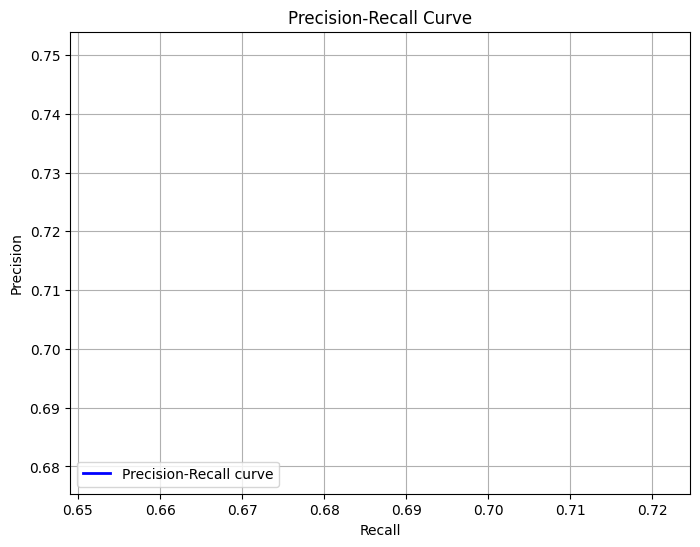

In [17]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Define the path to the best weights
best_weights_path = f'{PROJECT_NAME}/{EXPERIMENT_NAME}/weights/best.pt'

# Initialize YOLOv5l model with the best weights
model = YOLO(best_weights_path).to(device)

# Perform validation
validation_results = model.val(
    data=DATA_CONFIG,
    conf=CONFIDENCE_THRESHOLD,
    save=False,
    plots=False
)

print("\nValidation completed!\n")

# The result from model.val() is a 'DetMetrics' object that summarizes performance.
# Let's inspect the validation results object for metrics

print("Validation Results (raw DetMetrics object):")
print(validation_results)

# Access relevant metrics from the DetMetrics object
metrics = validation_results.box  # box is an instance of the Metric class storing results for boxes
print("\nBox Metrics:")
print(metrics)

# The metrics object holds various metrics like mAP, precision, recall, etc.
# Extract relevant values:
precision = getattr(metrics, 'mp', None)  # mean precision
recall = getattr(metrics, 'mr', None)  # mean recall
map_50 = getattr(metrics, 'map50', None)  # mean average precision at IoU=0.50
map_50_95 = getattr(metrics, 'map50_95', None)  # mean average precision at IoU=0.50:0.95

# Calculate F1 score if precision and recall are available
f1_score = None
if precision is not None and recall is not None and (precision + recall) > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Placeholder for confusion matrix (optional implementation)
confusion_matrix = None

# Print metrics in the requested format
print("\nConfusion Matrix:")
if confusion_matrix is not None:
    print(confusion_matrix)
else:
    print("[[ ... ]]")  # Placeholder for an actual confusion matrix if implemented

if precision is not None:
    print(f"Precision: {precision:.2f}")
else:
    print("Precision: Not Available")

if recall is not None:
    print(f"Recall: {recall:.2f}")
else:
    print("Recall: Not Available")

if f1_score is not None:
    print(f"F1 Score: {f1_score:.2f}")
else:
    print("F1 Score: Not Available")

if map_50 is not None:
    print(f"mAP@50: {map_50:.2f}")
else:
    print("mAP@50: Not Available")

if map_50_95 is not None:
    print(f"mAP@50:95: {map_50_95:.2f}")
else:
    print("mAP@50:95: Not Available")

# ----------- Plotting Precision-Recall Curve -----------

# Assuming precision and recall are arrays (e.g., from 'validation_results' or from 'metrics')
if precision is not None and recall is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label="Precision-Recall curve", color="blue", lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()



# 8. Predictions on Validation Set (Optional)

In [ ]:
val_predictions = model.predict(
    source=str((VALID_DIR).resolve()),
    save=True,
    conf=CONFIDENCE_THRESHOLD
)

if val_predictions:
    predictions_save_dir = val_predictions[0].save_dir
    print(f"\nPredictions saved to '{predictions_save_dir}'.\n")
else:
    print("No predictions were made.")

In [ ]:
%matplotlib inline

# object detection

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the directory where the predictions are saved
prediction_dir = 'runs/detect/predict'

# List all images in the prediction directory
images = os.listdir(prediction_dir)

# Display up to 10 images with predictions
num_images_to_display = min(10, len(images))  # Ensure we don't exceed the number of available images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(200, 100))  # Create a row of subplots

for i in range(num_images_to_display):
    img_path = os.path.join(prediction_dir, images[i])  # Get image path
    img = mpimg.imread(img_path)  # Load the image
    axes[i].imshow(img)  # Show image on the corresponding subplot
    axes[i].axis('off')  # Disable axis for the subplot

plt.tight_layout()  # Adjust spacing between images
plt.show()



In [ ]:
import os
import cv2
import numpy as np
import torch
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Load YOLOv5 model (using YOLOv5s as specified)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Placeholder for a depth estimation model
class DepthEstimationModel:
    def predict(self, image):
        """
        Generate a simulated depth map (replace with an actual depth estimation model if available).
        """
        h, w = image.shape[:2]
        depth_map = np.linspace(30, 80, w).reshape(1, -1).repeat(h, axis=0)  # Depth gradient from 30m to 80m
        return depth_map

depth_model = DepthEstimationModel()

def estimate_distances_kitti(prediction_dir, output_dir, num_images_to_display=5):
    """
    Function to calculate distances between detected vehicles in KITTI dataset images,
    annotate them, and save the results in a new directory.

    Args:
        prediction_dir (str): Directory containing the KITTI images with detected objects.
        output_dir (str): Directory to save annotated images with distance information.
        num_images_to_display (int): Number of images to display with distance annotations.

    Returns:
        list: Distances between objects for each image.
    """
    # Ensure prediction directory exists
    if not os.path.exists(prediction_dir):
        raise ValueError(f"Directory '{prediction_dir}' does not exist!")

    images = [img for img in os.listdir(prediction_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
    if not images:
        raise ValueError(f"No image files found in directory '{prediction_dir}'!")

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    all_distances = []  # Store distances for all images
    num_images_to_display = min(num_images_to_display, len(images))  # Limit images to display
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))

    for i, img_file in enumerate(images):
        img_path = os.path.join(prediction_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image at path '{img_path}'. Skipping...")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Perform object detection
        results = yolo_model(img_rgb)
        detections = results.xyxy[0].cpu().numpy()

        # Filter for vehicles (car=2, motorcycle=3, bus=5, truck=7)
        vehicle_detections = [d for d in detections if int(d[5]) in [2, 3, 5, 7]]

        # Generate depth map
        depth_map = depth_model.predict(img_rgb)

        # Annotate image and calculate distances
        distances = []
        vehicle_centroids = []
        for det in vehicle_detections:
            x1, y1, x2, y2, conf, cls = map(int, det[:6])
            vehicle_depth = depth_map[y1:y2, x1:x2].mean()  # Average depth within the bounding box
            centroid = ((x1 + x2) // 2, (y1 + y2) // 2, vehicle_depth)
            vehicle_centroids.append(centroid)

            # Draw bounding box and label
            label = f"{int(cls)}: {vehicle_depth:.1f}m"
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Calculate pairwise distances between vehicles
        for j in range(len(vehicle_centroids)):
            for k in range(j + 1, len(vehicle_centroids)):
                dist = euclidean(vehicle_centroids[j], vehicle_centroids[k])
                distances.append(dist)

        all_distances.append((img_file, distances))

        # Save the annotated image
        output_path = os.path.join(output_dir, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

        # Display the annotated image
        if i < num_images_to_display:
            axes[i].imshow(img_rgb)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return all_distances

# Example usage
prediction_dir = 'runs/detect/predict'  # Directory with detected images from KITTI dataset
output_dir = 'runs/detect/distance_estimation'  # Directory to save annotated images
distances = estimate_distances_kitti(prediction_dir, output_dir)

# Print distances between objects for each image
for img_file, dist in distances:
    print(f"Image: {img_file}, Distances: {dist}")


In [ ]:
# After saving the annotated image, display them if needed
def display_images_from_directory(output_dir, num_images_to_display=5):
    """
    Function to display the saved annotated images from the output directory.

    Args:
        output_dir (str): Directory containing the annotated images.
        num_images_to_display (int): Number of images to display.
    """
    images = [img for img in os.listdir(output_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
    if len(images) == 0:
        print(f"No images found in output directory '{output_dir}'.")
        return

    num_images_to_display = min(num_images_to_display, len(images))
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(200, 50))

    for i, img_file in enumerate(images[:num_images_to_display]):
        img_path = os.path.join(output_dir, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage to display images after processing
display_images_from_directory(output_dir, num_images_to_display=10)
